** Aim of the experiment **

* Setup a cross-validation framework for single and multiple models.

In [143]:
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

import time

sns.set_style('dark')

%run ../src/features/util.py
%run ../src/models/cross_validation.py

SEED = 1313141
np.random.seed(SEED)

In [158]:
# laod files
data = load_file('../data/processed/processed.feather')
train_mask = data.Target.notnull()

In [159]:
# encode detected camera
lbl = LabelEncoder()
data['DetectedCamera'] = lbl.fit_transform(data.DetectedCamera)

In [160]:
# add area
data['SignArea'] = np.log1p(data['SignHeight'] * data['SignWidth'])

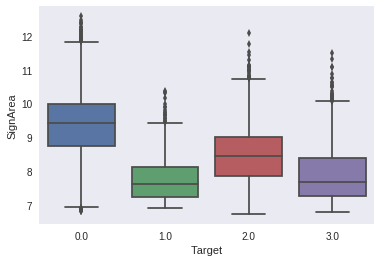

In [161]:
sns.boxplot(x='Target', y='SignArea', data=data.loc[train_mask, :]);

/home/abhishek/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


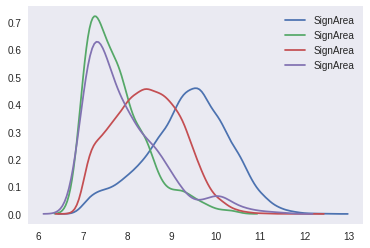

In [162]:
sns.kdeplot(data.loc[train_mask & (data.Target == 0), 'SignArea'])
sns.kdeplot(data.loc[train_mask & (data.Target == 1), 'SignArea'])
sns.kdeplot(data.loc[train_mask & (data.Target == 2), 'SignArea'])
sns.kdeplot(data.loc[train_mask & (data.Target == 3), 'SignArea']);

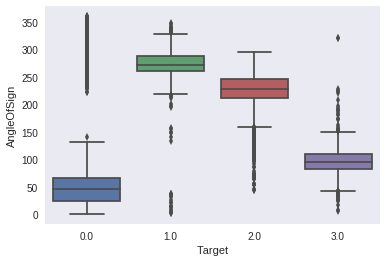

In [182]:
sns.boxplot(x='Target', y='AngleOfSign', data=data.loc[train_mask, :])

/home/abhishek/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


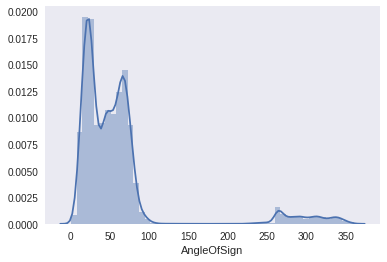

In [183]:
sns.distplot(data.loc[train_mask & (data.Target == 0.0), 'AngleOfSign'])

/home/abhishek/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


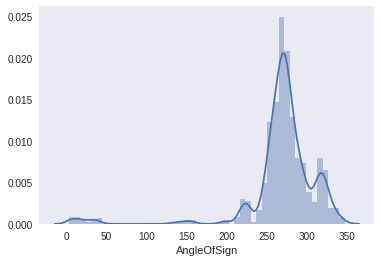

In [184]:
sns.distplot(data.loc[train_mask & (data.Target == 1.0), 'AngleOfSign'])

/home/abhishek/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


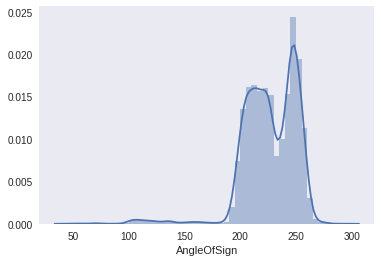

In [185]:
sns.distplot(data.loc[train_mask & (data.Target == 2.0), 'AngleOfSign'])

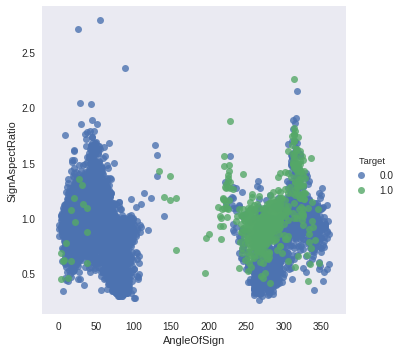

In [188]:
sns.lmplot(x='AngleOfSign', y='SignAspectRatio', hue='Target', data=data.loc[train_mask & (data.Target.isin([0, 1])), :], 
           fit_reg=False);

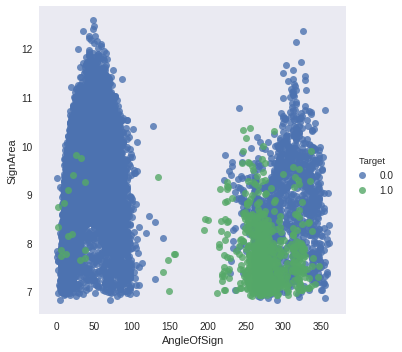

In [190]:
sns.lmplot(x='AngleOfSign', y='SignArea', hue='Target', data=data.loc[train_mask & (data.Target.isin([0, 1])), :], 
           fit_reg=False);

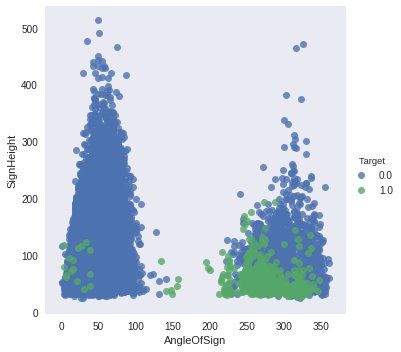

In [191]:
sns.lmplot(x='AngleOfSign', y='SignHeight', hue='Target', data=data.loc[train_mask & (data.Target.isin([0, 1])), :], 
           fit_reg=False);

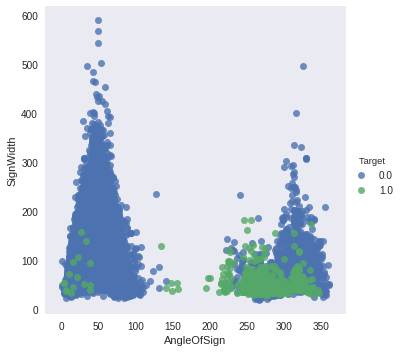

In [192]:
sns.lmplot(x='AngleOfSign', y='SignWidth', hue='Target', data=data.loc[train_mask & (data.Target.isin([0, 1])), :], 
           fit_reg=False);

In [189]:
lbl.classes_

array(['Front', 'Left', 'Rear', 'Right'], dtype=object)

In [129]:
def cross_validate(X, y, model, ret_fold_preds=False,
                   save_folds=False, plot_cv_scores=False):
    """
    Stratified K-Fold with 10 splits and then save each fold
    and analyze the performance of the model on each fold
    """
    
    skf = StratifiedKFold(n_splits=10, random_state=SEED)
    fold_counter = 0
    
    cv_scores = []
    preds     = []
    
    for (itr, ite) in tqdm_notebook(skf.split(X, y)):
        Xtr = X.iloc[itr]
        ytr = y.iloc[itr]
        
        Xte = X.iloc[ite]
        yte = y.iloc[ite]
        
        print('Class Distribution in the training fold \n', ytr.value_counts(normalize=True))
        print('Class Distribution in the test fold \n', yte.value_counts(normalize=True))
        
        
        if save_folds:
            save_file(pd.concat((Xtr, ytr), axis='columns'), '../data/processed/train_fold%s.feather'%(fold_counter))
            save_file(pd.concat((Xte, yte), axis='columns'), '../data/processed/test_fold%s.feather'%(fold_counter))
        
        print('Training model')
        start_time = time.time()
        model.fit(Xtr, ytr)
        end_time   = time.time()
        
        print('Took: {} seconds to train model'.format(end_time - start_time))
        
        start_time  = time.time()
        fold_preds  = model.predict_proba(Xte)
        
        if ret_fold_preds:
            preds.append(fold_preds)
        end_time    = time.time()
        
        print('Took: {} seconds to generate predictions'.format(end_time - start_time))
        
        fold_score = log_loss(yte, fold_preds)
        print('Fold log loss score: {}'.format(fold_score))
        
        cv_scores.append(fold_score)
        print('='*75)
        print('\n')
        
    if plot_cv_scores:
        plt.scatter(np.arange(0, len(cv_scores)), cv_scores)
    
    print('Mean cv score: {} \n Std cv score: {}'.format(np.mean(cv_scores), np.std(cv_scores)))
    
    return preds

In [140]:
def cv_multiple_models(X, y, feature_sets, models):
    skf = StratifiedKFold(n_splits=10, random_state=SEED)
    
    model_scores = [[] for _ in models]
    cv_scores    = []
    fold_index   = 0
    
    for (itr, ite) in tqdm_notebook(skf.split(X, y)):
        Xtr = X.iloc[itr]
        ytr = y.iloc[itr]
        
        Xte = X.iloc[ite]
        yte = y.iloc[ite]
        
        predictions = []
        
        for i, model in enumerate(models):
            print('Training model: {}'.format(i))
            curr_model = model.fit(Xtr.loc[:, feature_sets[i]], ytr)
            model_pred = curr_model.predict_proba(Xte.loc[:, feature_sets[i]])
            predictions.append(model_pred)
            model_scores[i].append(log_loss(yte, model_pred))
        
        predictions = np.array(predictions)
        vot = predictions[1]
        
        for i in range(1, len(predictions)):
            vot = vot + predictions[i]
        
        vot /= len(predictions)
        
        print('final ensemble predictions shape ', vot.shape)
        
        curr_metric = log_loss(yte, vot)
        cv_scores.append(curr_metric)
        print('split # {}, score = {}, models scores std = {}'\
            .format(fold_index, curr_metric,
            np.std([scr[fold_index] for scr in model_scores])))
        
        fold_index += 1
        
    print()
    print(cv_scores)
    print(np.mean(cv_scores), np.std(cv_scores))
    print()

** Feature Engineering **

In [171]:
diff_from_normal = 1 - data.SignAspectRatio
data = data.assign(diff_from_normal=diff_from_normal)

In [172]:
X = data.loc[train_mask, ['AngleOfSign', 'diff_from_normal', 'DetectedCamera', 'SignArea']]
y = data.loc[train_mask, 'Target']

Xtest = data.loc[~train_mask, ['AngleOfSign', 'diff_from_normal', 'DetectedCamera', 'SignArea']]

In [173]:
# train test splt
params = {
    'stratify': y,
    'test_size': .2,
    'random_state': SEED
}

X_train, X_test, y_train, y_test = train_test_split(X, y, **params)

In [99]:
model = RandomForestClassifier(n_estimators=500, max_depth=3, random_state=SEED)
params = {
    'ret_fold_preds': True,
    'save_folds': False,
    'plot_cv_scores': False
}

fold_preds_rf_single = cross_validate(X_train[['AngleOfSign']], y_train, model, **params)

Class Distribution in the training fold 
 0.0    0.554136
2.0    0.406994
3.0    0.021330
1.0    0.017540
Name: Target, dtype: float64
Class Distribution in the test fold 
 0.0    0.554221
2.0    0.406818
3.0    0.021429
1.0    0.017532
Name: Target, dtype: float64
Training model
Took: 3.8827943801879883 seconds to train model
Took: 0.13825106620788574 seconds to generate predictions
Fold log loss score: 0.145082224627137


Class Distribution in the training fold 
 0.0    0.554152
2.0    0.406980
3.0    0.021329
1.0    0.017539
Name: Target, dtype: float64
Class Distribution in the test fold 
 0.0    0.554076
2.0    0.406950
3.0    0.021436
1.0    0.017538
Name: Target, dtype: float64
Training model
Took: 3.628566265106201 seconds to train model
Took: 0.14249634742736816 seconds to generate predictions
Fold log loss score: 0.136495298370954


Class Distribution in the training fold 
 0.0    0.554152
2.0    0.406980
3.0    0.021329
1.0    0.017539
Name: Target, dtype: float64
Class Dist

In [178]:
model = RandomForestClassifier(n_estimators=500, max_depth=3, min_samples_split=5, oob_score=True, random_state=SEED)

params = {
    'ret_fold_preds': True,
    'save_folds': False,
    'plot_cv_scores': False
}

fold_preds_rf = cross_validate(X_train[['DetectedCamera']], y_train, model, **params)

Class Distribution in the training fold 
 0.0    0.554136
2.0    0.406994
3.0    0.021330
1.0    0.017540
Name: Target, dtype: float64
Class Distribution in the test fold 
 0.0    0.554221
2.0    0.406818
3.0    0.021429
1.0    0.017532
Name: Target, dtype: float64
Training model
Took: 3.093052864074707 seconds to train model
Took: 0.13678479194641113 seconds to generate predictions
Fold log loss score: 0.2688470350019929


Class Distribution in the training fold 
 0.0    0.554152
2.0    0.406980
3.0    0.021329
1.0    0.017539
Name: Target, dtype: float64
Class Distribution in the test fold 
 0.0    0.554076
2.0    0.406950
3.0    0.021436
1.0    0.017538
Name: Target, dtype: float64
Training model
Took: 3.0129261016845703 seconds to train model
Took: 0.14077162742614746 seconds to generate predictions
Fold log loss score: 0.27316310816313555


Class Distribution in the training fold 
 0.0    0.554152
2.0    0.406980
3.0    0.021329
1.0    0.017539
Name: Target, dtype: float64
Class D

In [72]:
def calculate_correlation(fold_preds_rf, fold_preds_et):
    for i in tqdm_notebook(range(10)):
        print(pd.DataFrame(np.array(fold_preds_rf)[i]).corrwith(pd.DataFrame(np.array(fold_preds_et)[i])))
        print('='*75)
        print('\n')

In [100]:
calculate_correlation(fold_preds_rf, fold_preds_rf_single)

0    0.987087
1    0.863032
2    0.977405
3    0.727727
dtype: float64


0    0.985401
1    0.872084
2    0.974789
3    0.711128
dtype: float64


0    0.986668
1    0.868482
2    0.977516
3    0.732948
dtype: float64


0    0.987522
1    0.842471
2    0.980576
3    0.771660
dtype: float64


0    0.987040
1    0.821052
2    0.975794
3    0.685999
dtype: float64


0    0.986541
1    0.864597
2    0.976169
3    0.713241
dtype: float64


0    0.987846
1    0.859417
2    0.977447
3    0.705725
dtype: float64


0    0.987156
1    0.867646
2    0.976411
3    0.727719
dtype: float64


0    0.986932
1    0.871475
2    0.978696
3    0.752672
dtype: float64


0    0.985247
1    0.860868
2    0.974573
3    0.697396
dtype: float64





In [175]:
feature_sets = [['AngleOfSign'], ['AngleOfSign', 'diff_from_normal'],
                ['AngleOfSign', 'diff_from_normal'], ['DetectedCamera', 'diff_from_normal']
               ]

models = [RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth=3, random_state=SEED),
          ExtraTreesClassifier(n_estimators=750, n_jobs=-1, max_depth=7, random_state=SEED),
          xgb.XGBClassifier(seed=SEED), xgb.XGBClassifier(seed=SEED)
         ]

cv_multiple_models(X_train, y_train, feature_sets, models)

Training model: 0
Training model: 1
Training model: 2
Training model: 3
final ensemble predictions shape  (3080, 4)
split # 0, score = 0.1814038816602714, models scores std = 0.05325645820099475
Training model: 0
Training model: 1
Training model: 2
Training model: 3
final ensemble predictions shape  (3079, 4)
split # 1, score = 0.174887093756338, models scores std = 0.05480846721050632
Training model: 0
Training model: 1
Training model: 2
Training model: 3
final ensemble predictions shape  (3079, 4)
split # 2, score = 0.1784553668762593, models scores std = 0.056583095686234444
Training model: 0
Training model: 1
Training model: 2
Training model: 3
final ensemble predictions shape  (3079, 4)
split # 3, score = 0.17733389943048333, models scores std = 0.047956875440751646
Training model: 0
Training model: 1
Training model: 2
Training model: 3
final ensemble predictions shape  (3079, 4)
split # 4, score = 0.18481503289936138, models scores std = 0.051426083593380904
Training model: 0
Tra